In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower

import seaborn as sns

print('Using CAMB %s installed at %s' % (camb.__version__, os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

Using CAMB 1.6.1 installed at C:\Users\rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\camb


In [11]:
def prior(batch_size, seed=None):
    
    rng = np.random.default_rng(seed)

    H0 = rng.uniform(50, 90, size=batch_size)
    Omega_m = rng.uniform(0.2, 0.4, size=batch_size)
    n_s = rng.uniform(0.9, 1.0, size=batch_size)

    return dict(H0 = H0,
                Omega_m = Omega_m,
                n_s = n_s)

### $y_{obs} \sim P(y|\theta^*)$, True Data Generating Process with noise

$$
\epsilon(k) \sim \mathcal{N}\left(0, \left[\text{noise\_level} \cdot P(k)\right]^2 \right)
$$


$$
P_{\text{noisy}}(k) = P(k) + \epsilon(k)
$$


In [143]:
def generate_PK(H0, Omega_m, n_s, k_vals=None, noise_level=0.2, seed=None):
    """
    Generate noisy matter power spectrum P(k) from given cosmological parameters.

    Parameters:
        H0 (float): Hubble constant (km/s/Mpc)
        Omega_m (float): total matter density (Ω_m)
        n_s (float): spectral index
        k_vals (np.array or None): k values (1/Mpc). Default: logspace from 1e-3 to ~3.16
        noise_level (float): relative Gaussian noise (e.g., 0.05 = 5%)

    Returns:
        noisy_P_k (np.array): noisy matter power spectrum at redshift z=0
    """
    # Default k range: safe values for CAMB
    if k_vals is None:
        k_vals = np.logspace(-4, 0.5, 1024)


    ## To calculate the physical densities from the densities 
    # Baryon density
    Omega_b = 0.05
    
    # Cold dark matter density
    Omega_c = Omega_m - Omega_b

    # dimensionless Hubble parameter
    h = H0 / 100

    
    # physical densities
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2


    # Setup CAMB
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(k_vals))

    # Run CAMB and get P(k)
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(k_vals))
    P_k = PK.P(0, k_vals)

     # Conditional RNG
    if seed is not None:
        rng = np.random.default_rng(seed)  # reproducible
    else:
        rng = np.random.default_rng()      # fresh random

    # Add heteroscedastic Gaussian noise.
    # Noise is added according to the scale of P_k which make more realistic observations
    noise = rng.normal(0, noise_level * P_k)
    P_k_noisy = P_k + noise

    return {
        'k': k_vals,
        'P_k_noisy': P_k_noisy,
        'P_k_clean': P_k  # optional, useful for comparison
    }

$\theta^*$, True parameter from Planck 2018

In [144]:
# Define the true cosmological parameters
theta_star = {
    'H0': 67.4,
    'Omega_m': 0.315,
    'n_s': 0.965
}

In [178]:
# Generate the noisy power spectrum using theta_star
Pk_obs = generate_PK(
    H0=theta_star['H0'],
    Omega_m=theta_star['Omega_m'],
    n_s=theta_star['n_s'],
    noise_level=0.2,   # 20% relative Gaussian noise
    seed=42            # Optional, for reproducibility
)

In [179]:
print(len(Pk_test))

1


In [180]:
print(Pk_test['P_k_noisy'].shape)

(1024,)


### P(k) vs k_vals

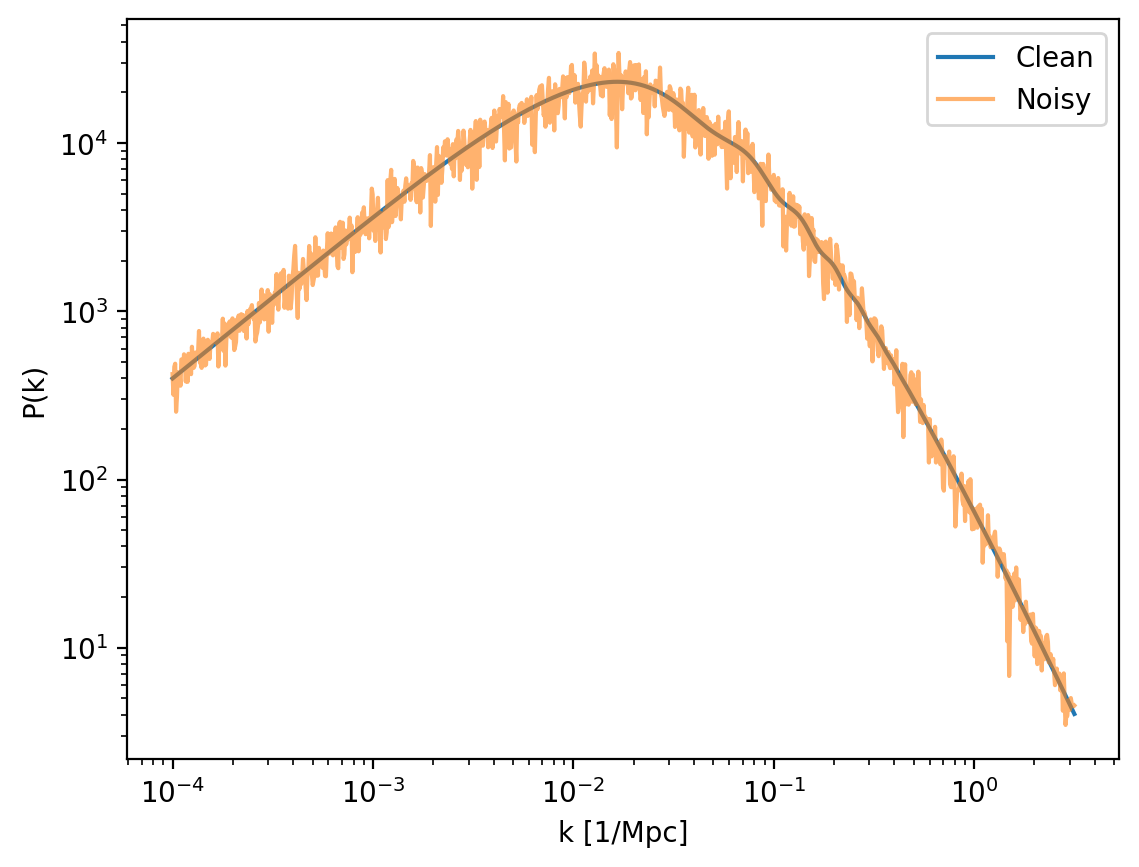

In [181]:
## Ploting the P_obs vs k_vals
plt.loglog(Pk_obs['k'], Pk_obs['P_k_clean'], label='Clean')
plt.loglog(Pk_obs['k'], Pk_obs['P_k_noisy'], label='Noisy', alpha=0.6)
plt.xlabel('k [1/Mpc]')
plt.ylabel('P(k)')
plt.legend()
plt.show()

### $f(P\_k))$, Density of Power Spectrum 

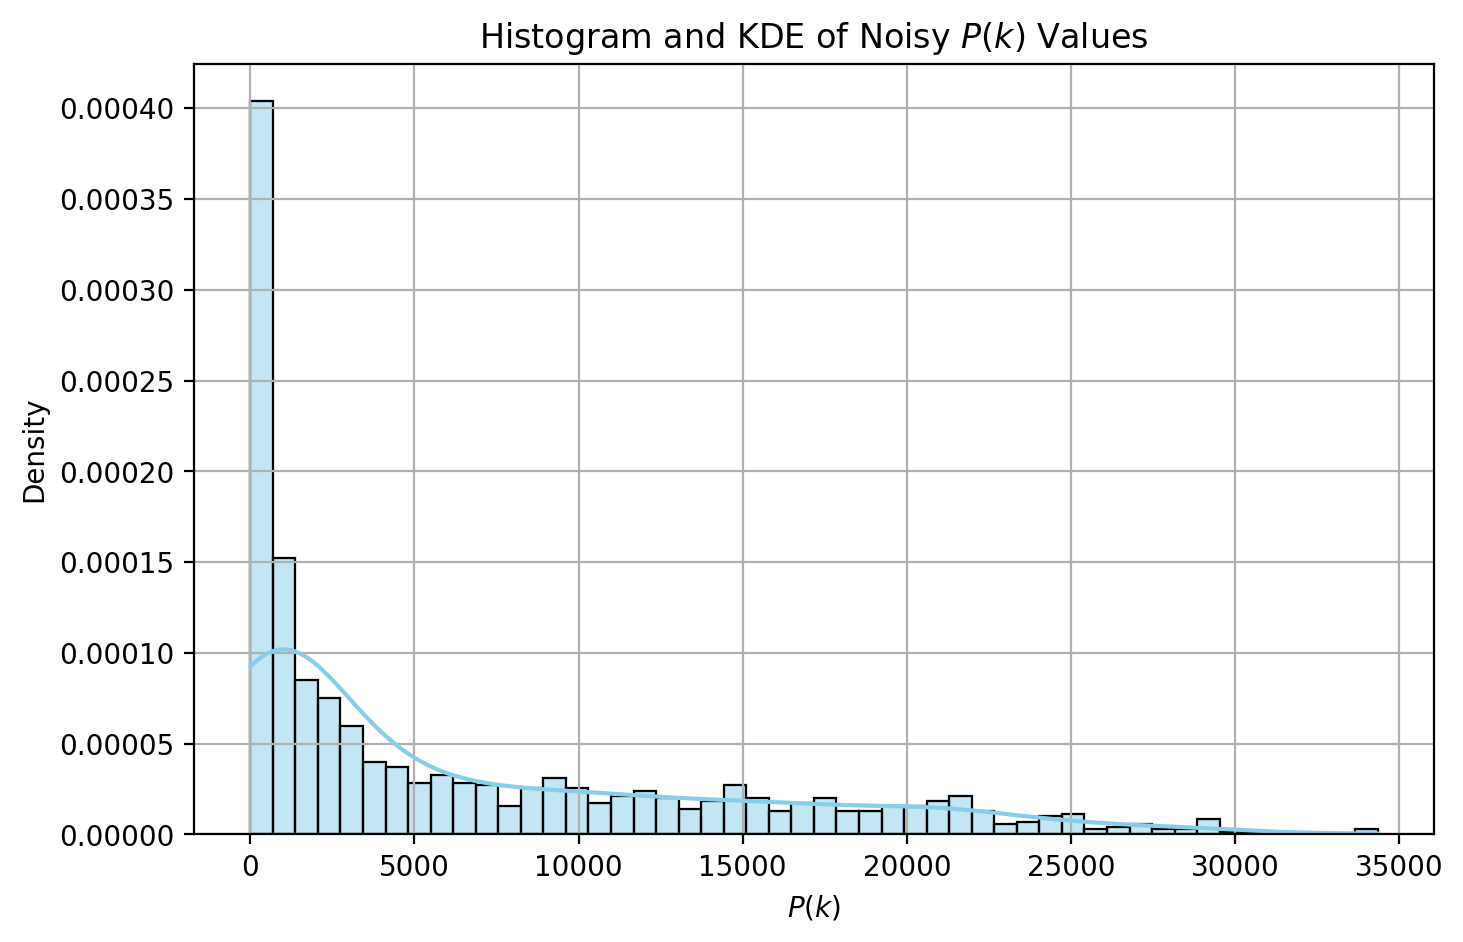

In [182]:
# Extract the noisy P(k) values
P_k_noisy = Pk_obs['P_k_noisy']

# Plot histogram and KDE
plt.figure(figsize=(8, 5))
sns.histplot(P_k_noisy, bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')

plt.title('Histogram and KDE of Noisy $P(k)$ Values')
plt.xlabel('$P(k)$')
plt.ylabel('Density')
plt.grid(True)
plt.show()


### $(\theta^{(s)}) \sim P(\theta)$, Sample from the Prior

In [183]:
def prior(seed=None):
    rng = np.random.default_rng(seed)

    H0 = rng.uniform(50, 90)
    Omega_m = rng.uniform(0.2, 0.4)
    n_s = rng.uniform(0.9, 1.0)

    return {
        'H0': H0,
        'Omega_m': Omega_m,
        'n_s': n_s
    }


In [184]:
prior()

{'H0': 82.6154002038756,
 'Omega_m': 0.3250407826976095,
 'n_s': 0.9618596439341288}

### $(y^{(s)}) \sim P(y | \theta)$, Sample from the Likelihood
The same function but with just one output of length of k_vals

In [232]:
def likelihood(H0, Omega_m, n_s, k_vals=None, noise_level=0.2, seed=None):
    """
        Same function as generate_PK(), the only difference is the single output "P_K_noisy".
        Redefinng, just make it Likelihood.
        Also, note that n = len(k_vals) = 128
    """
    # Default k range: safe values for CAMB
    if k_vals is None:
        k_vals = np.logspace(-4, 0.5, 128) 


    ## To calculate the physical densities from the densities 
    
    # Baryon density (Well Know Constant from Plank 2018)
    Omega_b = 0.05
    
    # Cold dark matter density
    Omega_c = Omega_m - Omega_b

    # dimensionless Hubble parameter
    h = H0 / 100

    
    # physical densities
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2


    # Setup CAMB
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(k_vals))

    # Run CAMB and get P(k)
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(k_vals))
    P_k = PK.P(0, k_vals)

     # Conditional RNG
    if seed is not None:
        rng = np.random.default_rng(seed)  # reproducible
    else:
        rng = np.random.default_rng()      # fresh random

    # Add heteroscedastic Gaussian noise.
    # Noise is added according to the scale of P_k which make more realistic observations
    noise = rng.normal(0, noise_level * P_k)
    P_k_noisy = P_k + noise
    P_k_noisy = P_k_noisy.reshape(-1, 1)

    return {'P_k_noisy': P_k_noisy}

# Testing Prior and Likelihood

In [233]:
theta_test = prior()
print(theta_test)

{'H0': 81.35507852271965, 'Omega_m': 0.3038759858867524, 'n_s': 0.9521499525679155}


In [234]:
# Generate the noisy power spectrum using theta_star
Pk_test = likelihood(
    H0=theta_test['H0'],
    Omega_m=theta_test['Omega_m'],
    n_s=theta_test['n_s'],
    noise_level=0.2   # 20% relative Gaussian noise
)

In [235]:
Pk_test['P_k_noisy'].shape


(128, 1)

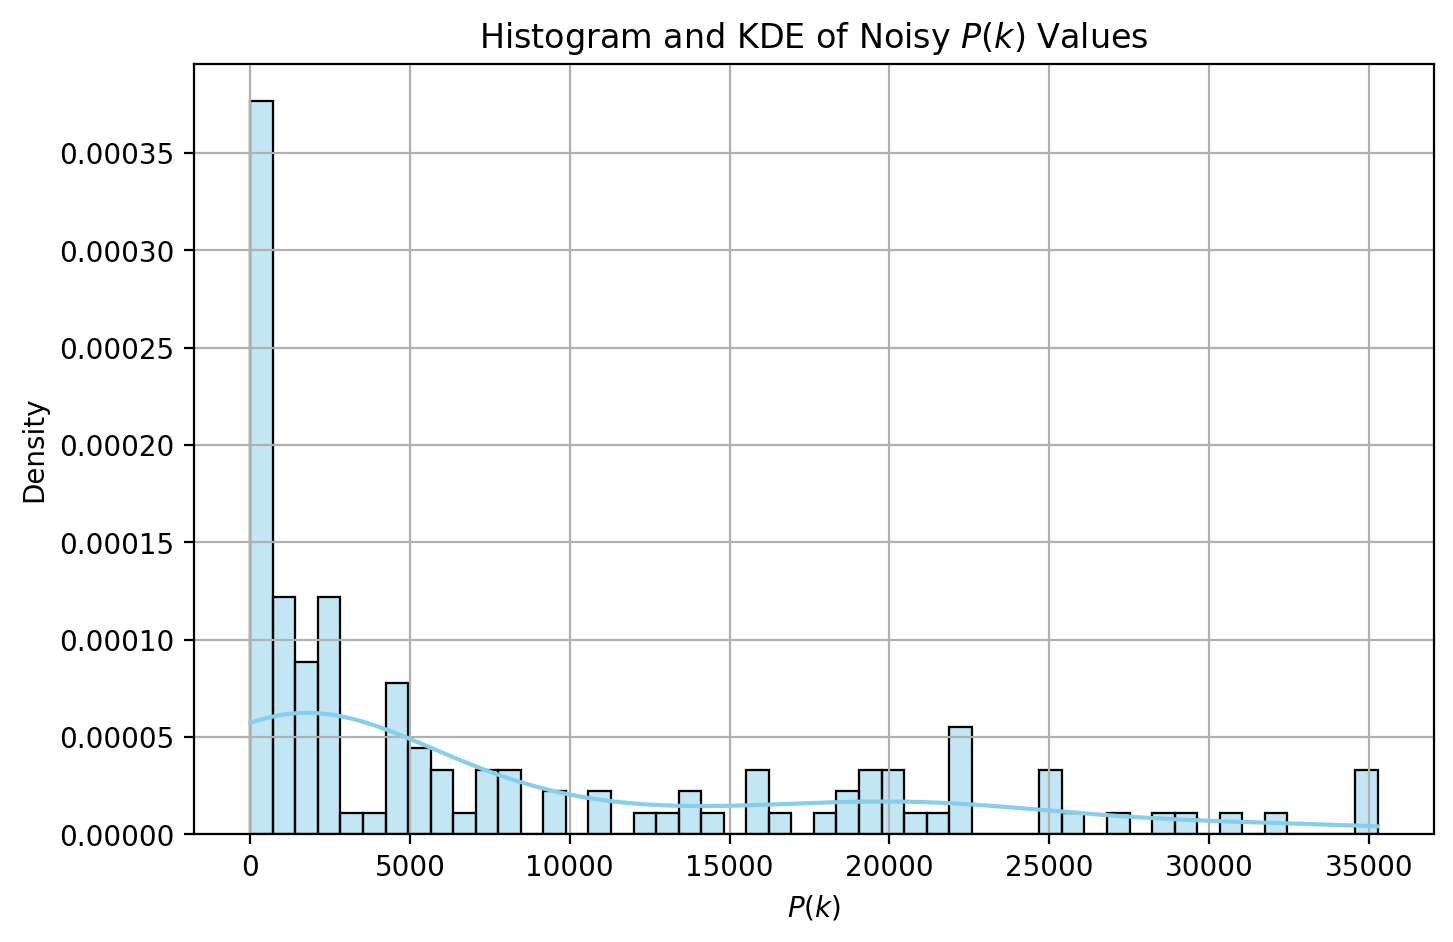

In [236]:
# Plot histogram and KDE
plt.figure(figsize=(8, 5))
sns.histplot(Pk_test['P_k_noisy'].flatten(), bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')

plt.title('Histogram and KDE of Noisy $P(k)$ Values')
plt.xlabel('$P(k)$')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Bayes Flow Workflow

In [237]:
import bayesflow as bf

# $(\theta^{(s)}, y^{(s)}) \sim P(\theta, y)$,  Sample from the Joint Distribution

### Simulator

In [238]:
simulator = bf.make_simulator([prior, likelihood])

In [239]:
# simulator.sample(2)

###  Adapter 

In [240]:
adapter = (
    bf.Adapter()
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("P_k_noisy", "summary_variables")
)


In [241]:
# adapter(dataset)

### Summary Network

In [242]:
summary_network = bf.networks.DeepSet()

### Inference Network

In [243]:
# inference_network = bf.networks.CouplingFlow(transform="spline")
inference_network = bf.networks.CouplingFlow() # affine

### Approximator

approximator = bf.approximators.ContinuousApproximator(
 inference_network=inference_network,
 summary_network=summary_network
 adapter=adapter
 )

In [244]:
workflow = bf.BasicWorkflow(
     inference_network=inference_network,
     summary_network=summary_network,
     adapter=adapter,
     simulator=simulator
)

In [248]:
#training_data = workflow.simulate(10000)
#validation_data = workflow.simulate(1000)

In [246]:
# history = workflow.fit_online(epochs=3, num_batches_per_epoch= 5, batch_size=64, validation_data=10)

In [249]:
training_data['P_k_noisy'].shape

(10000, 128, 1)

In [ ]:
history = workflow.fit_offline(
    data = training_data,
    epochs=100,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data
)


In [139]:
history = workflow.fit_offline(
    data=training_data, 
    epochs=10, 
    batch_size=64, 
    validation_data = validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.2637 - val_loss: 4.2252
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2439 - val_loss: 4.2268
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.2792 - val_loss: 4.2279
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2669 - val_loss: 4.2287
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.2794 - val_loss: 4.2293
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.2672 - val_loss: 4.2298
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.2502 - val_loss: 4.2302
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2544 - val_loss: 4.2305
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.2693 - val_loss: 4.2308
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.2871 - val_loss: 4.2310


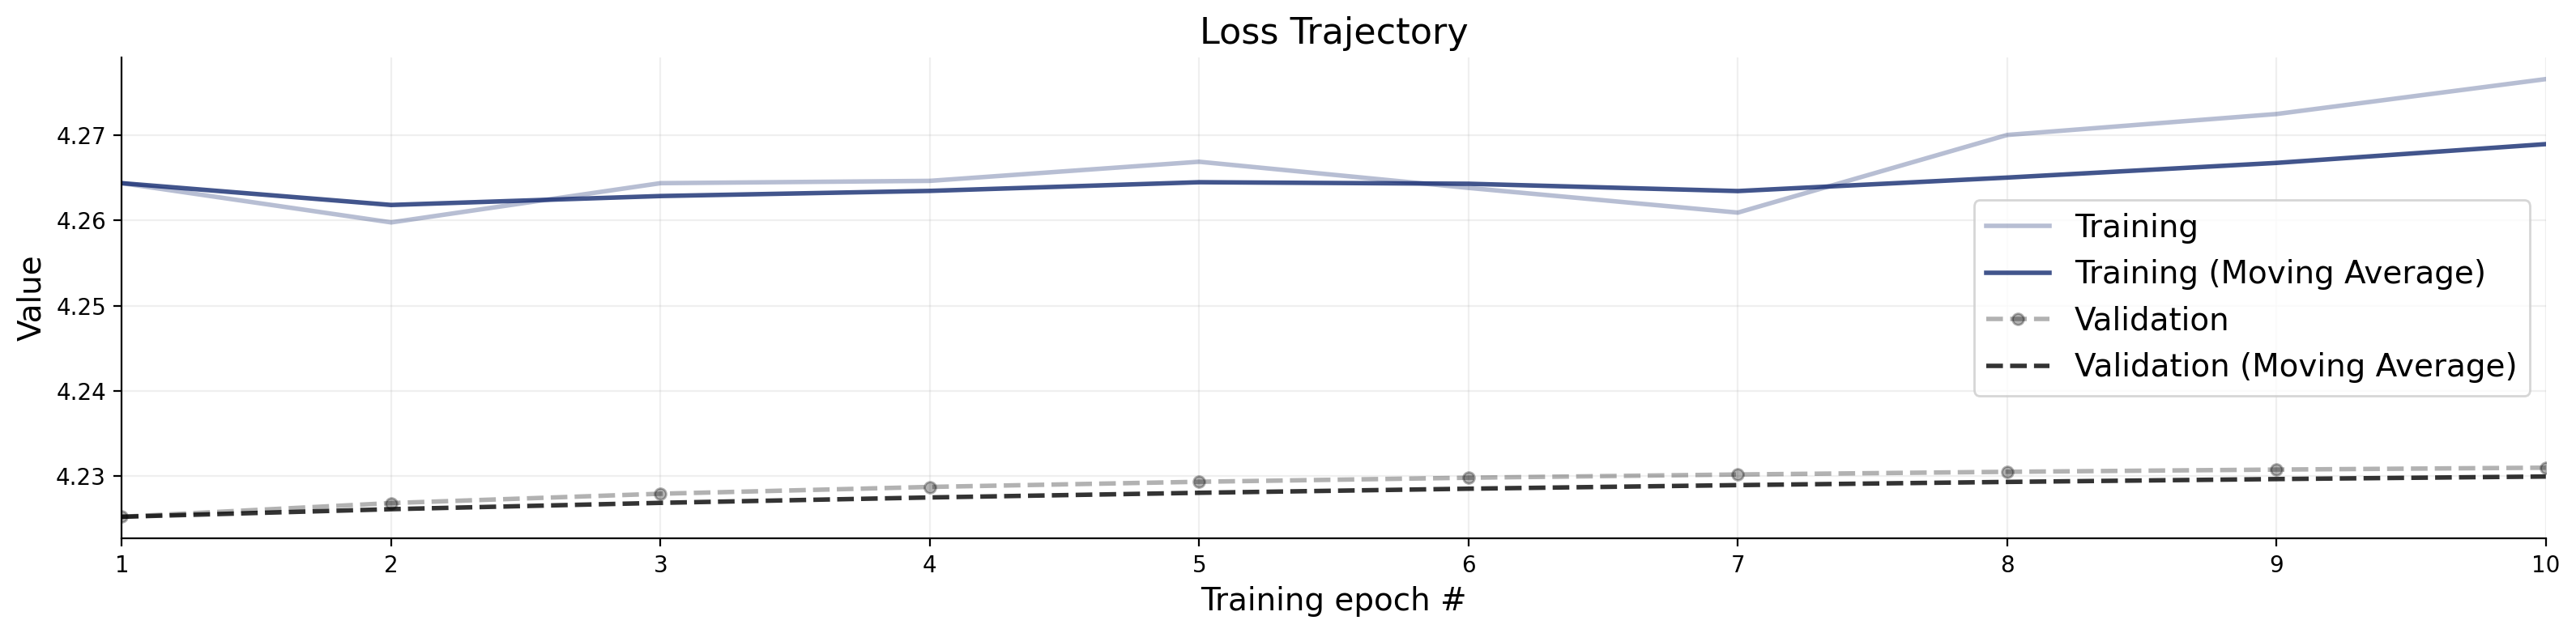

In [140]:
f = bf.diagnostics.plots.loss(history)

### Validation Set 

In [ ]:
# Set the number of posterior draws you want to get
num_datasets = 300
num_samples = 1000

# Simulate 300 scenarios
test_sims = workflow.simulate(num_datasets)

# Obtain num_samples posterior samples per scenario
samples = workflow.sample(conditions=test_sims, num_samples=num_samples)

In [ ]:
f = bf.diagnostics.plots.calibration_histogram(samples, test_sims)

# *) Fitting the model 